In [1]:
import glob as glob
import os
import numpy as np
import mne 
import shutil
from mne.datasets import eegbci
from mne.datasets import sleep_physionet
import matplotlib.pyplot as plt
import pandas as pd
from mne.preprocessing import (ICA, corrmap, create_ecg_epochs,
                               create_eog_epochs)
import torch
import numpy as np
import platform, os, re, multiprocessing
import pyedflib
import time  # Import the time module
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import platform, os, re, multiprocessing
import pandas as pd
import pyedflib
import mne
import matplotlib.pyplot as plt
import time  # Import the time module
import os
import mne
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.pipeline import make_pipeline
import glob as glob
import numpy as np
import mne
import shutil
from mne.datasets import eegbci
from mne.datasets import sleep_physionet
import pandas as pd
from mne.preprocessing import (ICA, corrmap, create_ecg_epochs,
                               create_eog_epochs)
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from datetime import timedelta
from mne.datasets import sample
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
import glob
import os

path = "/mnt/data_lab513/data_thesis_duchuy/physionet.org/files/capslpdb/1.0.0/"
raw_list = []

for i in range(1, 30):  # Adjust the range as needed based on the number of files you have
    pattern = f"n{i}.edf"
    file_path = os.path.join(path, pattern)
    if os.path.exists(file_path):
        raw_list.append(file_path)

print(raw_list)

['/mnt/data_lab513/data_thesis_duchuy/physionet.org/files/capslpdb/1.0.0/n2.edf', '/mnt/data_lab513/data_thesis_duchuy/physionet.org/files/capslpdb/1.0.0/n3.edf', '/mnt/data_lab513/data_thesis_duchuy/physionet.org/files/capslpdb/1.0.0/n4.edf', '/mnt/data_lab513/data_thesis_duchuy/physionet.org/files/capslpdb/1.0.0/n5.edf', '/mnt/data_lab513/data_thesis_duchuy/physionet.org/files/capslpdb/1.0.0/n10.edf', '/mnt/data_lab513/data_thesis_duchuy/physionet.org/files/capslpdb/1.0.0/n11.edf', '/mnt/data_lab513/data_thesis_duchuy/physionet.org/files/capslpdb/1.0.0/n16.edf']


In [3]:
# Define the desired sampling frequency
desired_sfreq = 128

# Read each file and append to a list of Raw objects
raw_objects = []
for file in raw_list:
    raw = mne.io.read_raw_edf(file, preload=True, verbose=0, infer_types=True)
    raw_objects.append(raw)

# Resample each Raw object to the desired sampling frequency
for raw_obj in raw_objects:
    raw_obj.resample(desired_sfreq)

print(raw_objects)

[<RawEDF | n2.edf, 15 x 5644800 (44100.0 s), ~646.0 MB, data loaded>, <RawEDF | n3.edf, 23 x 4231808 (33061.0 s), ~742.6 MB, data loaded>, <RawEDF | n4.edf, 17 x 4574720 (35740.0 s), ~593.4 MB, data loaded>, <RawEDF | n5.edf, 23 x 4024448 (31441.0 s), ~706.2 MB, data loaded>, <RawEDF | n10.edf, 18 x 3763200 (29400.0 s), ~516.8 MB, data loaded>, <RawEDF | n11.edf, 22 x 4047360 (31620.0 s), ~679.4 MB, data loaded>, <RawEDF | n16.edf, 5 x 3942400 (30800.0 s), ~150.4 MB, data loaded>]


Plotting Raw object 1...
Using matplotlib as 2D backend.


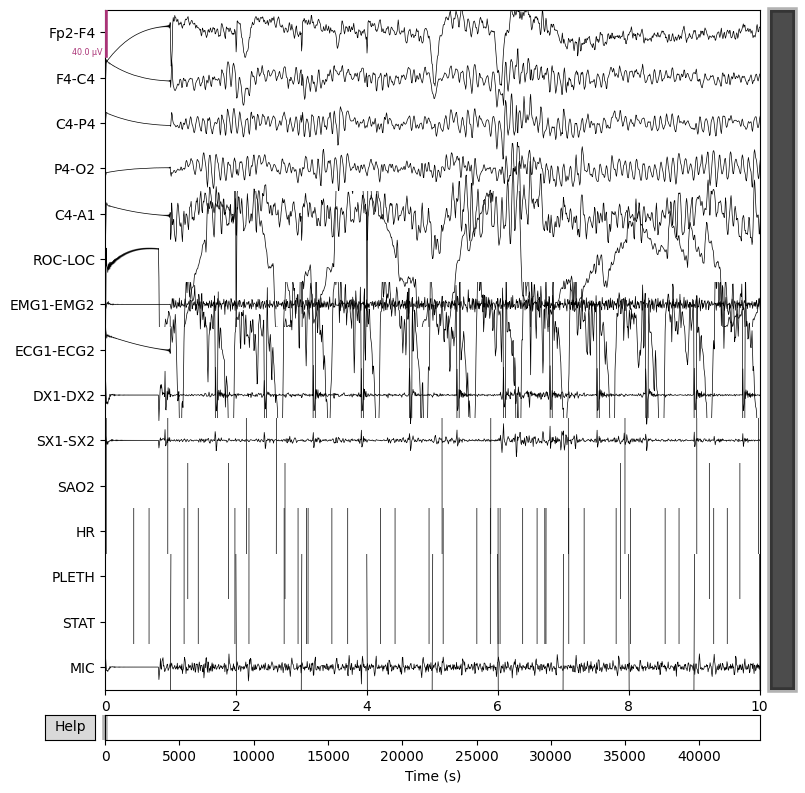

Plotting Raw object 2...


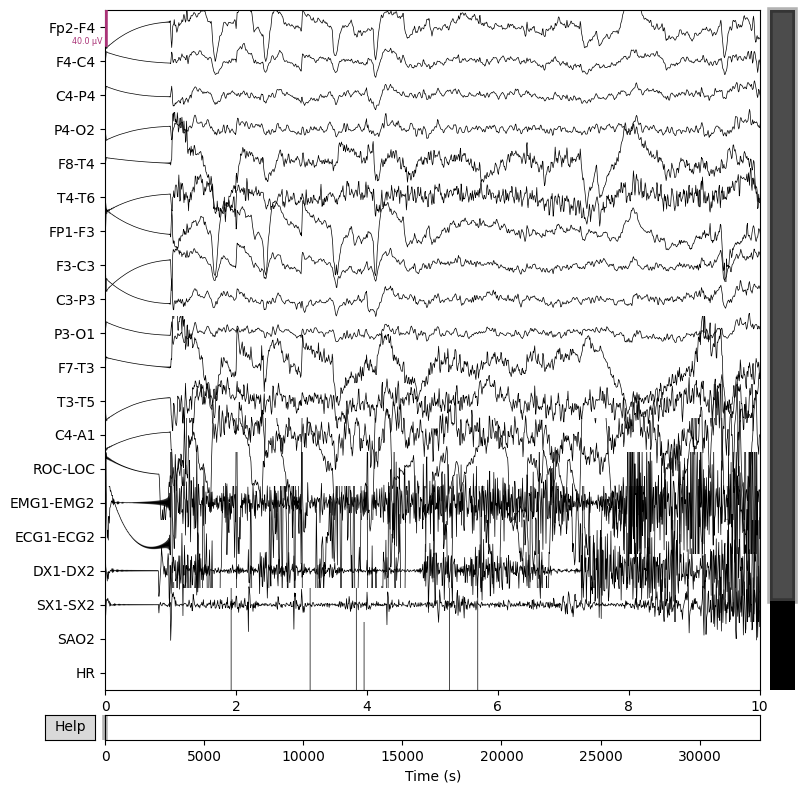

Plotting Raw object 3...


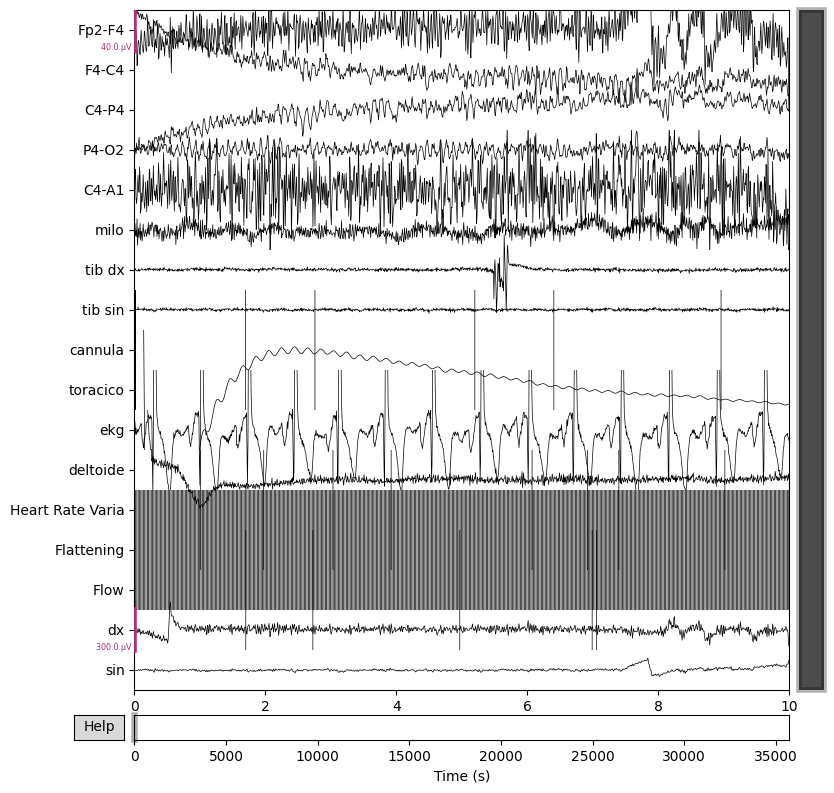

Plotting Raw object 4...


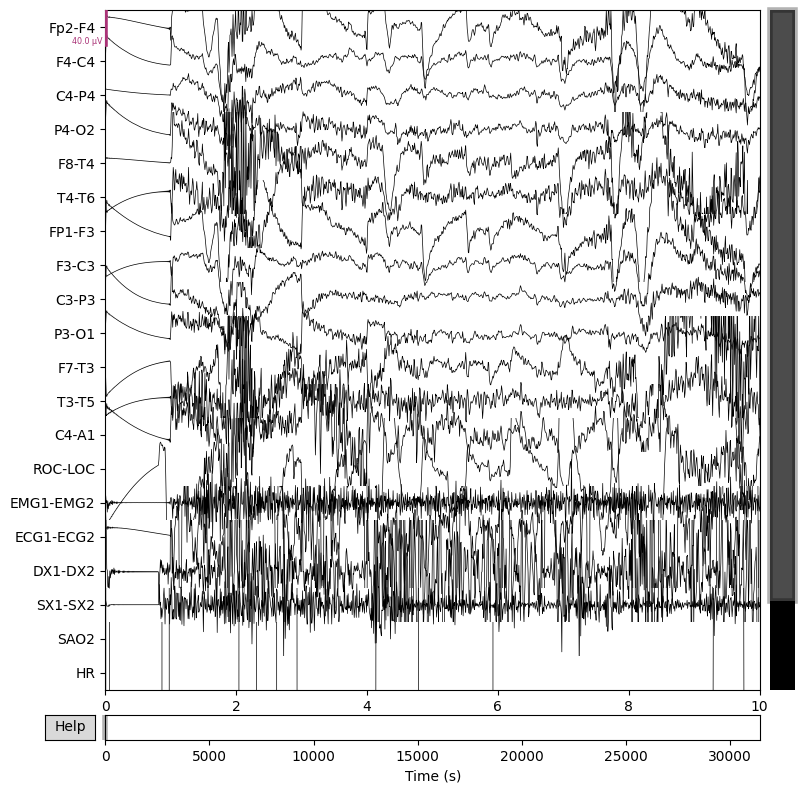

Plotting Raw object 5...


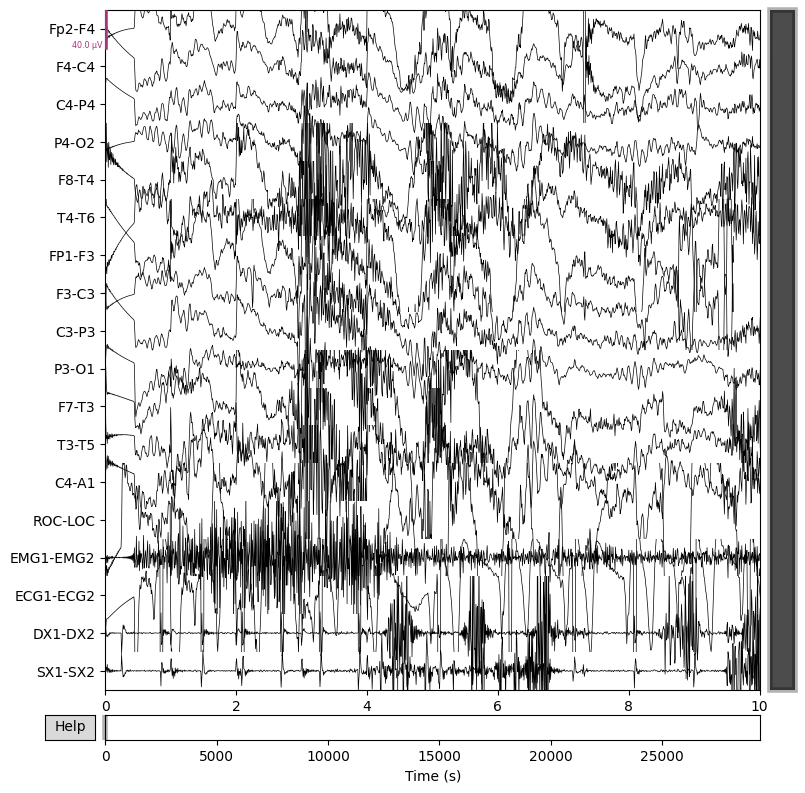

Plotting Raw object 6...


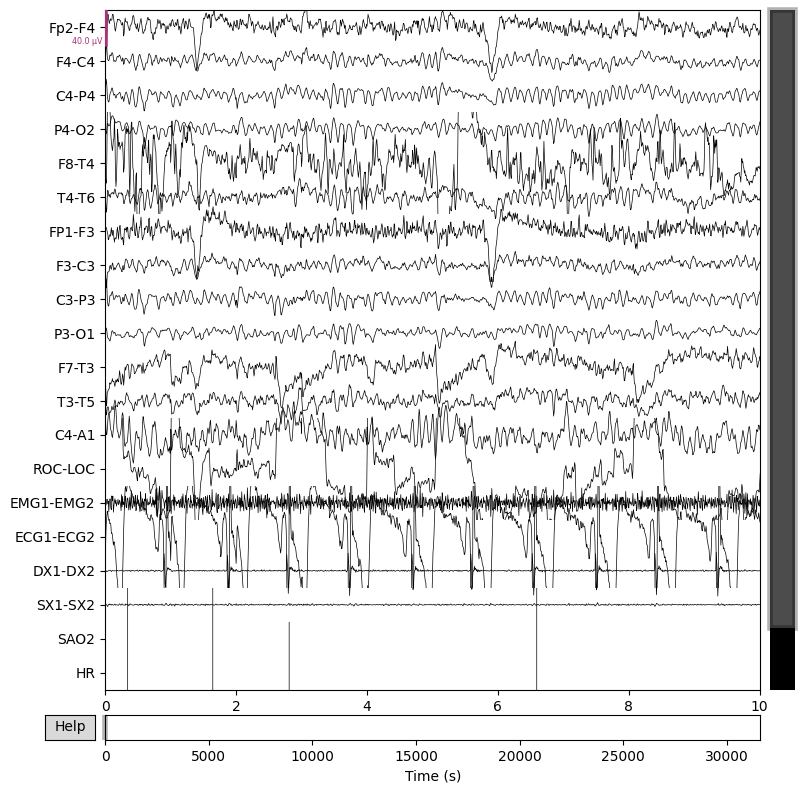

Plotting Raw object 7...


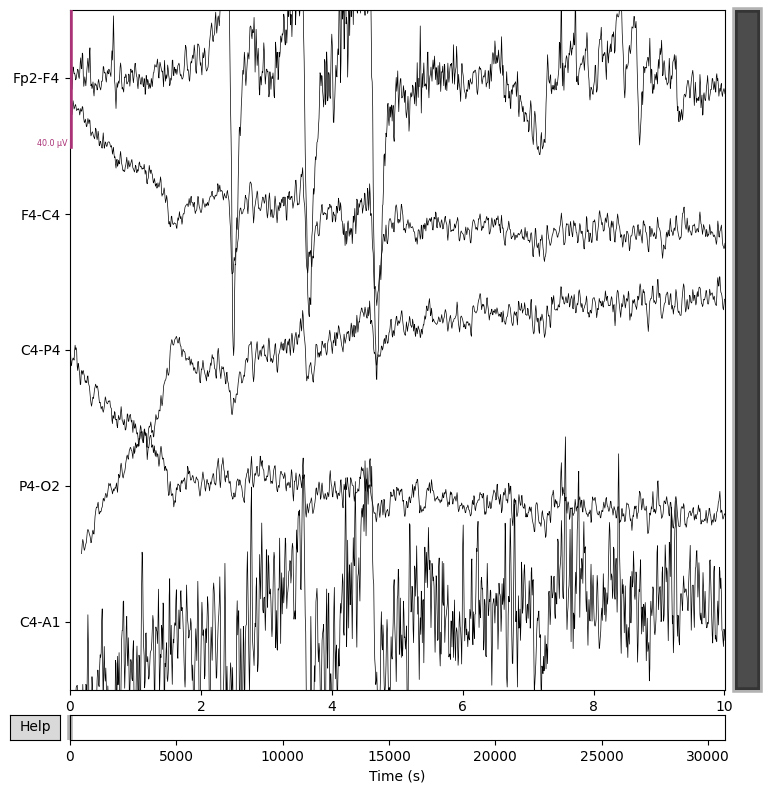

In [4]:
for i, raw in enumerate(raw_objects):
    print(f"Plotting Raw object {i+1}...")
    raw.plot()

In [5]:
path_csv = "/home/Duchuy220602/thesis/file_csv"
csv_list = []

for i in range(1, 30):  # Adjust the range as needed based on the number of files you have
    file_pattern = f"n{i}.csv"
    file_path = os.path.join(path_csv, file_pattern)
    if os.path.exists(file_path):
        csv_list.append(file_path)


for i in range(len(raw_objects)):
    raw = raw_objects[i]
    csv = csv_list[i]

    df = pd.read_csv(csv)

    # Convert the 'Time [hh:mm:ss]' column to a time format
    df['Time [hh:mm:ss]'] = pd.to_datetime(df['Time [hh:mm:ss]'], format='%H:%M:%S').dt.time

    # Extract the necessary columns from your DataFrame
    duration = df['Duration[s]']
    description = df['Sleep Stage']

    # Convert onset times to seconds
    onset = list(range(0, len(df)))  # Replace with your actual onset times

    # Create MNE Annotations
    my_annot = mne.Annotations(onset=onset, duration=duration, description=description)

    # Set annotations on the copied EEG data
    raw.set_annotations(my_annot)

    # Print the annotations
    print(raw.annotations)

<Annotations | 1677 segments: MT (4), R (239), S1 (54), S2 (796), S3 ...>
<Annotations | 1351 segments: R (151), S1 (184), S2 (600), S3 (128), S4 ...>
<Annotations | 1354 segments: MT (1), R (188), S1 (78), S2 (522), S3 ...>
<Annotations | 1266 segments: MT (21), R (199), S1 (22), S2 (565), S3 ...>
<Annotations | 1553 segments: R (232), S1 (71), S2 (633), S3 (242), S4 ...>
<Annotations | 1111 segments: MT (1), R (215), S1 (2), S2 (347), S3 (61), ...>
<Annotations | 1416 segments: MT (1), R (380), S1 (12), S2 (349), S3 (95), ...>


In [10]:
# Define the current and new channel names
current_channel_names = ['Fp2F4', 'F3A2', 'F4A1', 'C3A2', 'C4A1','F4C4','C4P4','P4O2']
new_channel_names = ['Fp2-F4','F3-A2', 'F4-A1', 'C3-A2', 'C4-A1','F4-C4','C4-P4','P4-O2']

# Iterate over the list of Raw objects
for i in range(len(raw_objects)):
    raw = raw_objects[i]
    
    # Check if the current Raw object contains any of the channels to be renamed
    if any(channel in raw.ch_names for channel in current_channel_names):
        # Create a channel map that maps the old channel names to the new channel names
        channel_map = {current_channel_names[i]: new_channel_names[i] for i in range(len(current_channel_names)) if current_channel_names[i] in raw.ch_names}

        # Rename the channels in the Raw object
        raw.rename_channels(channel_map)

        # Print the new channel names
        print(raw.ch_names)

In [11]:
# Define a dictionary mapping channel names to their types
channel_types = {
"Fp2-F4": "eeg",
"F4-C4": "eeg",
"C4-P4": "eeg",
"P4-O2": "eeg",
"C4-A1": "eeg", 
}

# Define the default type for EEG channels
default_type = 'stim'

# Apply the channel type mapping to all Raw objects
for i in range(len(raw_objects)):
    raw = raw_objects[i]
    # Get the channel names that are present in both the Raw object and the channel_types dictionary
    common_channel_names = set(raw.ch_names) & set(channel_types.keys())
    if not common_channel_names:
        print(f"No common channels found between the Raw object and the channel_types dictionary. Skipping...")
        continue

    # Set channel types for selected channels
    channel_types_dict = {channel_name: channel_types.get(channel_name, default_type) for channel_name in common_channel_names}
    raw.set_channel_types(channel_types_dict)

    # Select only the EEG channels
    eeg_channel_names = [channel_name for channel_name in common_channel_names if channel_types_dict[channel_name] == 'eeg']
    if eeg_channel_names:
        raw = raw.pick(eeg_channel_names)
    else:
        print(f"No EEG channels found in the Raw object. Skipping...")

In [12]:
for i, raw in enumerate(raw_objects):
    print(f"Raw object {i+1} has {raw.info['nchan']} channels.")

Raw object 1 has 5 channels.
Raw object 2 has 5 channels.
Raw object 3 has 5 channels.
Raw object 4 has 5 channels.
Raw object 5 has 5 channels.
Raw object 6 has 5 channels.
Raw object 7 has 5 channels.


In [13]:
for i, raw in enumerate(raw_objects):
    print(f"Raw object {i+1} ({raw.filenames[0]})")

Raw object 1 (/mnt/data_lab513/data_thesis_duchuy/physionet.org/files/capslpdb/1.0.0/n2.edf)
Raw object 2 (/mnt/data_lab513/data_thesis_duchuy/physionet.org/files/capslpdb/1.0.0/n3.edf)
Raw object 3 (/mnt/data_lab513/data_thesis_duchuy/physionet.org/files/capslpdb/1.0.0/n4.edf)
Raw object 4 (/mnt/data_lab513/data_thesis_duchuy/physionet.org/files/capslpdb/1.0.0/n5.edf)
Raw object 5 (/mnt/data_lab513/data_thesis_duchuy/physionet.org/files/capslpdb/1.0.0/n10.edf)
Raw object 6 (/mnt/data_lab513/data_thesis_duchuy/physionet.org/files/capslpdb/1.0.0/n11.edf)
Raw object 7 (/mnt/data_lab513/data_thesis_duchuy/physionet.org/files/capslpdb/1.0.0/n16.edf)


In [ ]:
# for i, raw in enumerate(raw_objects):
#     print(f"Plotting Raw object {i+1}...")
#     raw.plot()

In [14]:
# If you want to concatenate the Raw objects into a single object
raw = mne.concatenate_raws(raw_objects)

In [15]:
# Print the concatenated annotations
print(raw.annotations)

<Annotations | 9740 segments: BAD boundary (6), EDGE boundary (6), MT ...>


In [16]:
raw.save('/home/Duchuy220602/thesis/modify_file/n_concatenated_raw.fif', overwrite=True)

Writing /home/Duchuy220602/thesis/modify_file/n_concatenated_raw.fif
Closing /home/Duchuy220602/thesis/modify_file/n_concatenated_raw.fif
[done]
